**IMPORTANT** <br> <ul> <li> Do **NOT** replace or remove this notebook (ipynb file)! Each cell has unique nbgrader's metadata and ID which, if changed outside the nbgrader, cannot pass the tests. Do **NOT** change the name of the file!</li> <li> To receive any credit, don't forget to **SUBMIT** your notebook when you are done! You can have multiple submissions before the deadline; only the last one is saved, including its timestamp.</li> <li>Before submitting, **Validate** your notebook to check if your codes pass all visible tests. </li> <li>Make sure you fill in any cell with the comment `# your code here`. Remove or comment the command `fail()` (in R), or `raise NotImplementedError` (in Python) and place your code there </li> </ul>

In [ ]:
NAME = "Christian Olivares-Rodriguez"

---

In [1]:
## Import some needed libraries
## Make sure you run this code first!

library(testthat)
library(digest)
library(stringr)

## Question 1.

In HW2 we predicted whether a person has heart disease or not using 14 variables/predictors using the Naive Bayes method in Python. This time, we will use logistic regression in R, and explore regularization a little bit as well, using the `glmnet` library.

Since DAT 401 is a prerequisite for DAT 402, this homework assumes some basic familiarity with R, but we will introduce all the glmnet-specific functions, etc.

The dataset we use can be found at <https://www.statlearning.com> as the file Heart.csv. 

Before loading the dataset, we first import some additional libraries needed for this assignment. To do that, run the following cell and take a look at which libraries we use.

In [3]:

library(glmnet) #to do logistic regression with regularization
library(latex2exp) #used for including some latex in plots
library(pROC) #used for plotting ROC curve



### Importing and Cleaning Data


<br>


Now let's load the dataset. Our output variable will be the final one, `AHD`, which is a binary variable (Yes/No) indicating the presence of angiographic heart disease.

Our goal is to predict the value of `AHD` (Yes or No) based on all the other variables.

In [4]:

heart = read.csv("Heart.csv")
head(heart)
dim(heart)



,PatientID,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD
,<int>,<int>,<int>,<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<fct>,<fct>
1,1,63,1,typical,145,233,1,2,150,0,2.3,3,0,fixed,No
2,2,67,1,asymptomatic,160,286,0,2,108,1,1.5,2,3,normal,Yes
3,3,67,1,asymptomatic,120,229,0,2,129,1,2.6,2,2,reversable,Yes
4,4,37,1,nonanginal,130,250,0,0,187,0,3.5,3,0,normal,No
5,5,41,0,nontypical,130,204,0,2,172,0,1.4,1,0,normal,No
6,6,56,1,nontypical,120,236,0,0,178,0,0.8,1,0,normal,No


[1] 303  15

Our R data frame object `heart` has some missing values, although only 6. Run the following code cells to see this.

In [5]:
#Total missing values:
sum(is.na(heart))

[1] 6

In [6]:
#Missing values by column:
apply(is.na(heart), MARGIN=2, FUN=sum)

PatientID       Age       Sex ChestPain    RestBP      Chol       Fbs   RestECG 
        0         0         0         0         0         0         0         0 
    MaxHR     ExAng   Oldpeak     Slope        Ca      Thal       AHD 
        0         0         0         0         4         2         0


### Part (a)

<br>

Let's deal with missing observations. As usual, one option is imputation. Since both our variables with missing data are categorical, we can impute using the mode. The following snippet of code would do so for the `Ca` variable:

```
most_freq = as.integer(names(sort(table(heart['Ca']), decreasing = TRUE)[1]))

heart[is.na(heart['Ca']),'Ca'] = most_freq
```

However, let's just keep things simple and drop the observations (rows) that contain missing data.

Change the data frame `heart` by dropping/omitting the rows with missing values (use the same name "heart" for the modified data frame). So, your code should be of the form

`heart = <some expression>`

<br>

The modified `heart` dataframe should have 297 rows/obs. 

In [7]:
# your code here

head(heart) #quick check

heart = na.omit(heart)

stopifnot(nrow(heart) == 297)

,PatientID,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD
,<int>,<int>,<int>,<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<fct>,<fct>
1,1,63,1,typical,145,233,1,2,150,0,2.3,3,0,fixed,No
2,2,67,1,asymptomatic,160,286,0,2,108,1,1.5,2,3,normal,Yes
3,3,67,1,asymptomatic,120,229,0,2,129,1,2.6,2,2,reversable,Yes
4,4,37,1,nonanginal,130,250,0,0,187,0,3.5,3,0,normal,No
5,5,41,0,nontypical,130,204,0,2,172,0,1.4,1,0,normal,No
6,6,56,1,nontypical,120,236,0,0,178,0,0.8,1,0,normal,No


In [8]:
## check whether heart is a data frame with correct dimensions

if (test_that(desc="", code={
    expect_equal(is.data.frame(heart), TRUE)
    }) != TRUE) stop("Sorry, wrong answer")

if (test_that(desc="", code={
    expect_equal(dim(heart), c(297,15))
    }) != TRUE) stop("Sorry, wrong dimensions")


Test passed 😀
Test passed 😀


### Train-Test Split

Next, we split our dataset into training and testing data at a 70/30 ratio. These two new data frames will be called `train` and `test`. 

We set the seed (to 1234) before randomly choosing 70% of the data as training data. Simply run the following cell to make this split.


In [9]:
set.seed(1234)
trainidx = sample(1:nrow(heart), size=0.7*nrow(heart), replace=FALSE)


train = heart[trainidx, ]
test = heart[-trainidx, ]

dim(train) #see the dimensions of train data frame


#check the proportions 70%-30% of data taken into the train and test data frames

paste("Train data actual proportion:", nrow(train)/nrow(heart))
paste("Test data actual proportion:", nrow(test)/nrow(heart))

[1] 207  15

[1] "Train data actual proportion: 0.696969696969697"

[1] "Test data actual proportion: 0.303030303030303"

<br>

We also create `X` and `y` as the predictors and target for the training data as follows. Note that we drop `PatientID` from the predictor matrix.

In [10]:

#Get response vector y and predictor matrix (in fact, data frame) X from heart data
y = train$AHD

X = train[, !(names(train) %in% c("PatientID","AHD"))] #all but PatientID and AHD
dim(X)

[1] 207  13

## Preprocessing Categorical Predictors

<br>

Our predictor matrix `X` is actually an R data frame. In order to use it in the `cv.glmnet()` function from `glmnet` library, we should convert it into an R matrix object. Furthermore, the function `cv.glmnet()` does not take care of categorical variables (by creating dummies) automatically. So, we need to preprocess categorical variables and code the levels into dummy variables.

By running the following cell, we can see that `ChestPain` and `Thal` are categorical variables, having 4 and 3 levels (i.e. categories), respectively.


In [11]:
str(X) #structure of X

'data.frame':	207 obs. of  13 variables:
 $ Age      : int  56 34 56 51 52 71 46 66 48 71 ...
 $ Sex      : int  1 1 1 1 1 0 0 1 1 0 ...
 $ ChestPain: Factor w/ 4 levels "asymptomatic",..: 3 4 1 1 3 2 3 1 3 1 ...
 $ RestBP   : int  130 118 125 140 134 110 105 120 130 112 ...
 $ Chol     : int  221 182 249 261 201 265 204 302 245 149 ...
 $ Fbs      : int  0 0 1 0 0 1 0 0 0 0 ...
 $ RestECG  : int  2 2 2 2 0 2 0 2 2 0 ...
 $ MaxHR    : int  163 174 144 186 158 130 172 151 180 125 ...
 $ ExAng    : int  0 0 1 1 0 0 0 0 0 0 ...
 $ Oldpeak  : num  0 0 1.2 0 0.8 0 0 0.4 0.2 1.6 ...
 $ Slope    : int  1 1 2 1 1 1 1 2 2 2 ...
 $ Ca       : int  0 0 1 0 1 1 0 0 0 0 ...
 $ Thal     : Factor w/ 3 levels "fixed","normal",..: 3 2 2 2 2 2 2 2 2 2 ...


#### To dummy up our categorical variables, we only need one line of code:

`X = model.matrix( ~ . , data=X)[,-1]`

By having `[,-1]` at the end we are dropping the first column of `model.matrix( ~ . , data=X)`, which is the column of 1s (for the intercept). Function `cv.glmnet()` needs a matrix of the predictors only, i.e. without these 1s. 

In [12]:
X = model.matrix( ~ . , data=X)[,-1]

dim(X)

X[1:5,]

[1] 207  16

,Age,Sex,ChestPainnonanginal,ChestPainnontypical,ChestPaintypical,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thalnormal,Thalreversable
289,56,1,0,1,0,130,221,0,2,163,0,0.0,1,0,0,1
102,34,1,0,0,1,118,182,0,2,174,0,0.0,1,0,1,0
112,56,1,0,0,0,125,249,1,2,144,1,1.2,2,1,1,0
134,51,1,0,0,0,140,261,0,2,186,1,0.0,1,0,1,0
99,52,1,0,1,0,134,201,0,0,158,0,0.8,1,1,1,0


Note that there are 3 dummies for the 4-level variable `ChestPain`. The level `asymptomatic` does not need a dummy, if we dummy up the other three levels. This is because when the sum of the three dummies is 0 (i.e. `ChestPain` value is none of the three named levels), this indicates the corresponding observation has level `asymptomatic`. Note also that the names of all dummies are a concatenation of the name of the variable (`ChestPain`) and the corresponding level.

Similarly, variable `Thal`, which has three levels, was converted to two dummy variables. As an overall consequence, instead of 13 columns, we now have 16.


### Ridge Regularization

<br>

Let us train a logistic regression model with ridge regularization,using cross-validation to tune the hyperparameter $\lambda$. For that purpose, we deploy the function `cv.glmnet()` from the library `glmnet`.

<br>

We will use both **deviance** $D = -2\ln L(\beta)=2\ell(\beta)$  (essentially equivalent to binary cross-entropy, and the most appropriate cost function for logistic regression), and **mean squared error** $MSE = \sum_i(y_i-\hat{y}_i)^2$ as measures of goodness of fit (not a very good measure for logistic regression, but we can still use it).


**Note**: In logistic regression (i.e. when the only values of the output are 0-1), we have that $\forall i, \,\,(y_i-\hat{y}_i)^2\in\{0,1\}$. So, $MSE$ = 1 - accuracy. Again, we would usually use cross-entropy/deviance for logistic regression.

Also, we will set the grid for $\lambda$ manually, rather than letting the function `cv.glmnet()` to decide for us. One should be cautions when setting the $\lambda$ grid manually, as sometimes that may lead to issues with convergence of the algorithm; also, it is less efficient. For more details, see the documentation for `cv.glmnet()`. We set the $\lambda$ grid manually here so that the plots are a bit nicer.

<br>

**Run the following cells and study the codes/commands and their outputs, as well as the comments that preceed the commands. The comments are explanations of the commands, and some of them are also hints for the parts that you need to do.**

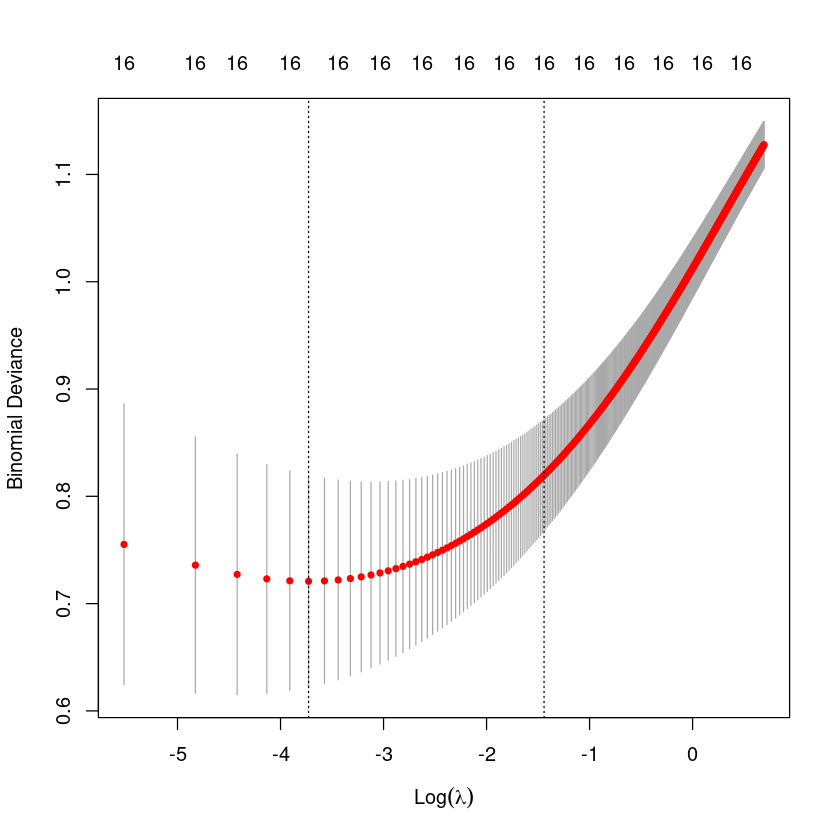

In [13]:
## Set lambda grid manually
mylambda=seq(0, 2, length.out = 500) 

#Here, we use deviance (cross-entropy) as a measure performance.

#by default, for logistic regression, type.measure is "deviance"
cvfit = cv.glmnet(X, y, family = "binomial", lambda = mylambda, type.measure="deviance",
                  nfolds = 10, alpha = 0)  #alpha- ridge:0, lasso:1

#plot performance based on deviance
#We get both the mean and standard deviation for every lambda value
#note on the x-axis in the plot is log(lambda). Thus, a higher value means stronger regularization
plot(cvfit)  


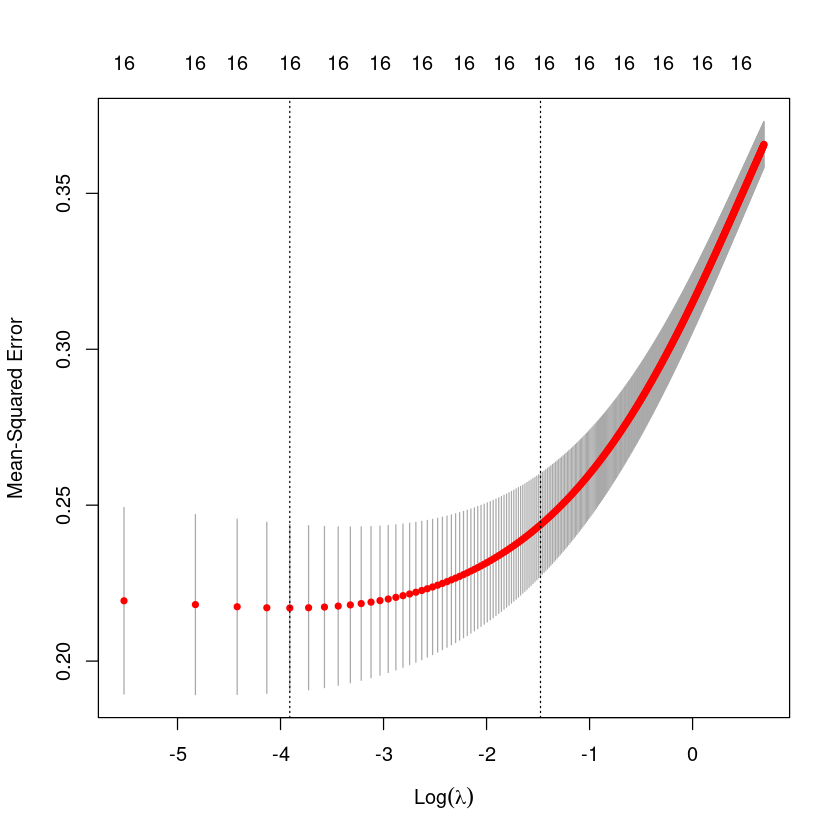

In [14]:
## Here, we use MSE as a measure of performance. 

#by default, for logistic regression, type.measure is "deviance"
cvfit = cv.glmnet(X, y, family = "binomial",lambda=mylambda, type.measure="mse",
                  nfolds = 10, alpha = 0)  #alpha- ridge:0, lasso:1

#plot performance based on mse
#We get both the mean and standard deviation for every lambda value
plot(cvfit)  #x-axis gives us log(lambda)



In [15]:
## Explore the structure of the object cvfit
str(cvfit)

List of 12
 $ lambda    : num [1:500] 2 2 1.99 1.99 1.98 ...
 $ cvm       : num [1:500] 0.366 0.366 0.365 0.365 0.365 ...
 $ cvsd      : num [1:500] 0.0074 0.0074 0.00741 0.00741 0.00742 ...
 $ cvup      : num [1:500] 0.373 0.373 0.373 0.373 0.372 ...
 $ cvlo      : num [1:500] 0.358 0.358 0.358 0.358 0.358 ...
 $ nzero     : Named int [1:500] 16 16 16 16 16 16 16 16 16 16 ...
  ..- attr(*, "names")= chr [1:500] "s0" "s1" "s2" "s3" ...
 $ call      : language cv.glmnet(x = X, y = y, lambda = mylambda, type.measure = "mse", nfolds = 10,      family = "binomial", alpha = 0)
 $ name      : Named chr "Mean-Squared Error"
  ..- attr(*, "names")= chr "mse"
 $ glmnet.fit:List of 13
  ..$ a0        : Named num [1:500] -0.643 -0.644 -0.645 -0.645 -0.646 ...
  .. ..- attr(*, "names")= chr [1:500] "s0" "s1" "s2" "s3" ...
  ..$ beta      :Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. .. ..@ i       : int [1:8000] 0 1 2 3 4 5 6 7 8 9 ...
  .. .. ..@ p       : int [1:501] 0 16 32 48 

In [16]:
## The value of optimal lambda that minimizes loss (we used mse most recently)
cvfit$lambda.min

## The value of optimal lambda by the 1SE rule
cvfit$lambda.1se

[1] 0.02004008

[1] 0.2284569

#### Fitted Coefficients

<br>

We can use either `coef(cvfit)` or `predict(object=cvfit, type="coefficients")` to see the values of all the fitted coefficients. We can also check they give the same values.

In [17]:
print("Using coef(cvfit):")
coef(cvfit)

cat("\n\n") #two newlines

print('Using predict(object=cvfit, type="coefficients"):')
predict(object=cvfit, type="coefficients")



[1] "Using coef(cvfit):"


17 x 1 sparse Matrix of class "dgCMatrix"
                              s1
(Intercept)         -1.771510074
Age                  0.013332188
Sex                  0.391555647
ChestPainnonanginal -0.484115962
ChestPainnontypical -0.288854820
ChestPaintypical    -0.853578455
RestBP               0.005747026
Chol                 0.001783589
Fbs                 -0.172892822
RestECG              0.078418209
MaxHR               -0.009302802
ExAng                0.386521774
Oldpeak              0.191841636
Slope                0.274192239
Ca                   0.408775268
Thalnormal          -0.488616002
Thalreversable       0.580587436



[1] "Using predict(object=cvfit, type=\"coefficients\"):"


17 x 1 sparse Matrix of class "dgCMatrix"
                      lambda.1se
(Intercept)         -1.771510074
Age                  0.013332188
Sex                  0.391555647
ChestPainnonanginal -0.484115962
ChestPainnontypical -0.288854820
ChestPaintypical    -0.853578455
RestBP               0.005747026
Chol                 0.001783589
Fbs                 -0.172892822
RestECG              0.078418209
MaxHR               -0.009302802
ExAng                0.386521774
Oldpeak              0.191841636
Slope                0.274192239
Ca                   0.408775268
Thalnormal          -0.488616002
Thalreversable       0.580587436

In [18]:
#check that all the coefficients are the same

all(coef(cvfit)==predict(object=cvfit, type="coefficients"))

[1] TRUE

Note that in the output `predict()` we see the fitted values correspond to optimal $\lambda$ based on the 1SE rule, which the `coef()` function also uses as a default.

The parameter `s` in the `predict()` function controls lambda. The default is equivalent to

`predict(object=cvfit, s=cvfit$lambda.1se, type="coefficients")` 

and gives the same output as 

`predict(object=cvfit, type="coefficients")` or as `coef(cvfit)`.

You can check that by running the following cell.

In [19]:
all(predict(object=cvfit, s=cvfit$lambda.1se, type="coefficients") == predict(object=cvfit, type="coefficients"))

[1] TRUE

### Predictions on the Train Data

<br>

To check performance, we use the `predict()` function and include the argument `newx`, which is the predictor matrix with the train data. The following gives us the prediction *probability*, not the predicted class. Note again we are using the train data here.

In [20]:
# We have train data, X, from above
# Just get the predictions:

phat = predict(object=cvfit, s=cvfit$lambda.1se, newx = X, type="response") #Use type="class" for binary class

length(phat)
dim(X)


[1] 207

[1] 207  16

### Measuring Performance

<br>

We will assess performance using the ROC curve and accuracy, as well the sensitivity and specifity. Note that we do this on the training data here.


#### ROC Curve


<br>

Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases



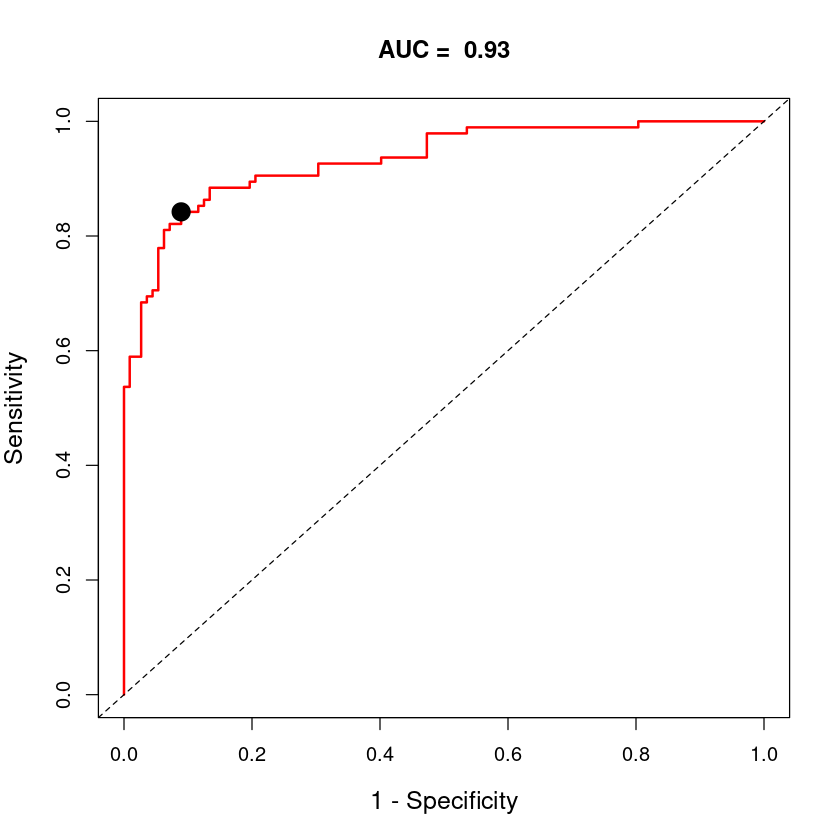

In [21]:
# Convert to binary:
ylogical = (y == "Yes")

#Get the curve:
ROC_curve = roc(response=ylogical, predictor=as.vector(phat))

#And the area under the curve:
AUC = auc(ROC_curve)

#Can get the point closest to upper left
best_point = coords(ROC_curve, "best", ret=c("threshold", "sens", "spec"))

#Plot 1 - specificity
plot(x=1 - ROC_curve$specificities, y=ROC_curve$sensitivities, main=paste("AUC = ", round(AUC,2)), 
     xlab="1 - Specificity", ylab="Sensitivity", type="l", col="red", lwd=2, cex=1.25, cex.lab=1.25)

abline(a=0, b=1, lty="dashed") #the diagonal line = Chance alone

#Plot the point corresponding to the best cutoff
points((1 - best_point$spec), best_point$sens, pch=21, bg='black', cex=2)


In [22]:
#explore the structure of AUC object, produced by the function auc()
#note that it is a numeric variable, a single value, but with a lot of attributes (i.e. info behind this single value)
str(AUC)

 'auc' num 0.933
 - attr(*, "partial.auc")= logi FALSE
 - attr(*, "percent")= logi FALSE
 - attr(*, "roc")=List of 15
  ..$ percent           : logi FALSE
  ..$ sensitivities     : num [1:208] 1 1 1 1 1 1 1 1 1 1 ...
  ..$ specificities     : num [1:208] 0 0.00893 0.01786 0.02679 0.03571 ...
  ..$ thresholds        : num [1:208] -Inf 0.0694 0.078 0.0804 0.0866 ...
  ..$ direction         : chr "<"
  ..$ cases             : num [1:95] 0.564 0.284 0.921 0.87 0.881 ...
  ..$ controls          : num [1:112] 0.4291 0.0792 0.3034 0.2751 0.2253 ...
  ..$ fun.sesp          :function (thresholds, controls, cases, direction)  
  ..$ auc               : 'auc' num 0.933
  .. ..- attr(*, "partial.auc")= logi FALSE
  .. ..- attr(*, "percent")= logi FALSE
  .. ..- attr(*, "roc")=List of 15
  .. .. ..$ percent           : logi FALSE
  .. .. ..$ sensitivities     : num [1:208] 1 1 1 1 1 1 1 1 1 1 ...
  .. .. ..$ specificities     : num [1:208] 0 0.00893 0.01786 0.02679 0.03571 ...
  .. .. ..$ threshold

In [23]:
#print the precise value of AUC
AUC

Area under the curve: 0.9334

#### Accuracy, Sensitivity, Specifity

As usual, we can construct a confusion matrix and extract the accuracy, sensitivity, and specifity.

In [24]:
#Create yhat vector based on the rule: yhat=Yes if phat>0.5; otherwise, yhat=No

yhat = ifelse(phat>0.5, "Yes", "No")

In [25]:
#And we can create a confusion matrix:
######

tbl = table(y, yhat)
tbl

     yhat
y      No Yes
  No  104   8
  Yes  18  77

In [26]:
# And finally, Accuracy (proportion of correctly predicted)
#####

acc = (tbl[1,1]+tbl[2,2])/sum(tbl)
acc

[1] 0.8743961

In [27]:
# Sensitivity
#####

sens = tbl[2,2] / (tbl[2,2] + tbl[2,1])
sens

[1] 0.8105263

In [28]:
# Specificity
#####

spec = tbl[1,1] / (tbl[1,1] + tbl[1,2])
spec

[1] 0.9285714

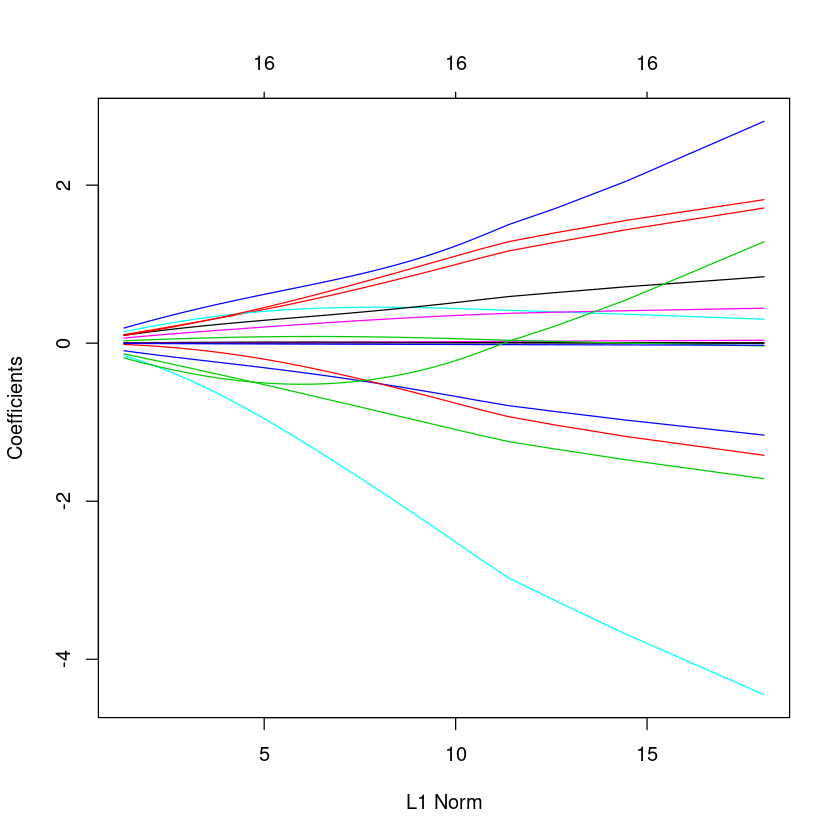

In [29]:
# Finally, note that we can quickly plot the coefficients for various models, i.e. various lambdas/flexibilities
######

plot(cvfit$glmnet.fit)

<br>

### Lasso Regularization


<br>

Now repeat some of the above steps, but for lasso regularization.

<br>

### Part (b)

Fit the lasso model using cross-validation with 10 folds. To do that, create object `cvfit` using the `cv.glmnet()` function. Use **deviance** as a loss function, i.e. as a measure of performance. Also, use the same `mylambda` as above as your vector of $\lambda$s.  Before running the `cv.glmnet()` function, set your random number seed to `1`.

If everything is okay, the estimated intercept coefficient should be `-0.85515095`; also the variables `Age`, `Chol`, `RestECG`, and `Thalnormal` will not appear in the model with optimal $\lambda$ based on the 1SE rule.

**IMPORTANT:** **Be sure to set your random number seed to `1`** or your results will not match those expected by the autograder.


In [11]:

# your code here
#code from this same assignment
set.seed(1)

mylambda = seq(0, 2, length.out = 500) 

cvfit = cv.glmnet(X, y, family = "binomial", lambda = mylambda, type.measure = "deviance", nfolds = 10, alpha = 1) #1)  # Setting alpha to 1 for lasso

str(cvfit)

## The value of optimal lambda that minimizes loss (we used mse most recently)
cvfit$lambda.min

## The value of optimal lambda by the 1SE rule
cvfit$lambda.1se

print("Using coef(cvfit):")
coef(cvfit)

cat("\n\n") #two newlines

print('Using predict(object=cvfit, type="coefficients"):')
predict(object = cvfit, type = "coefficients")

all(coef(cvfit) == predict(object = cvfit, type = "coefficients"))

all(predict(object = cvfit, s = cvfit$lambda.1se, type = "coefficients") == predict(object=cvfit, type="coefficients"))



ERROR: Error in nrow(x): object 'X' not found


In [52]:
#Check out our coefficients:
coef(cvfit)

17 x 1 sparse Matrix of class "dgCMatrix"
                             s1
(Intercept)         -0.85515095
Age                  .         
Sex                  0.39613283
ChestPainnonanginal -0.72014753
ChestPainnontypical -0.05373977
ChestPaintypical    -1.62194001
RestBP               0.00683900
Chol                 .         
Fbs                 -0.02970809
RestECG              .         
MaxHR               -0.01488785
ExAng                0.37434341
Oldpeak              0.35105037
Slope                0.28686163
Ca                   0.93447940
Thalnormal           .         
Thalreversable       1.40149307

In [53]:
#check whether the intercept coefficient is -0.85515095

if (test_that(desc="", code={
    expect_equal(abs(coef(cvfit)[1] - (-0.85515095)) < 1.e-5, TRUE)
    }) != TRUE) stop("Sorry, wrong answer")

Test passed 🎉


In [54]:
#check whether the Age variable does not appear in the cvfit model (i.e. its coef. is 0) 

if (test_that(desc="", code={
    expect_equal(coef(cvfit)[2], 0)
    }) != TRUE) stop("Sorry, wrong answer")


#check also the 3rd, 6th and 7th coefficient
if (test_that(desc="", code={
    expect_equal(norm(coef(cvfit)[c(3,6,7)] - c(0.39613283,-1.62194001,0.00683900),type="2") < 1.e-5, TRUE)
    }) != TRUE) stop("Sorry, wrong answer")


Test passed 🥳
Test passed 🎉


In [55]:
#check whether cvfit is correct (hidden tests)



Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”


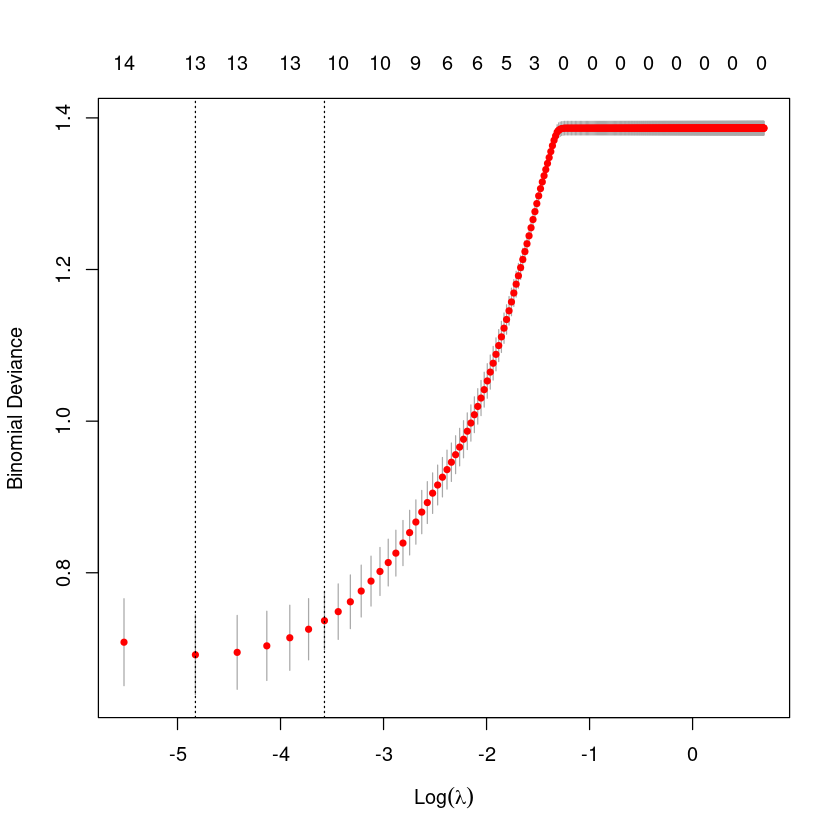

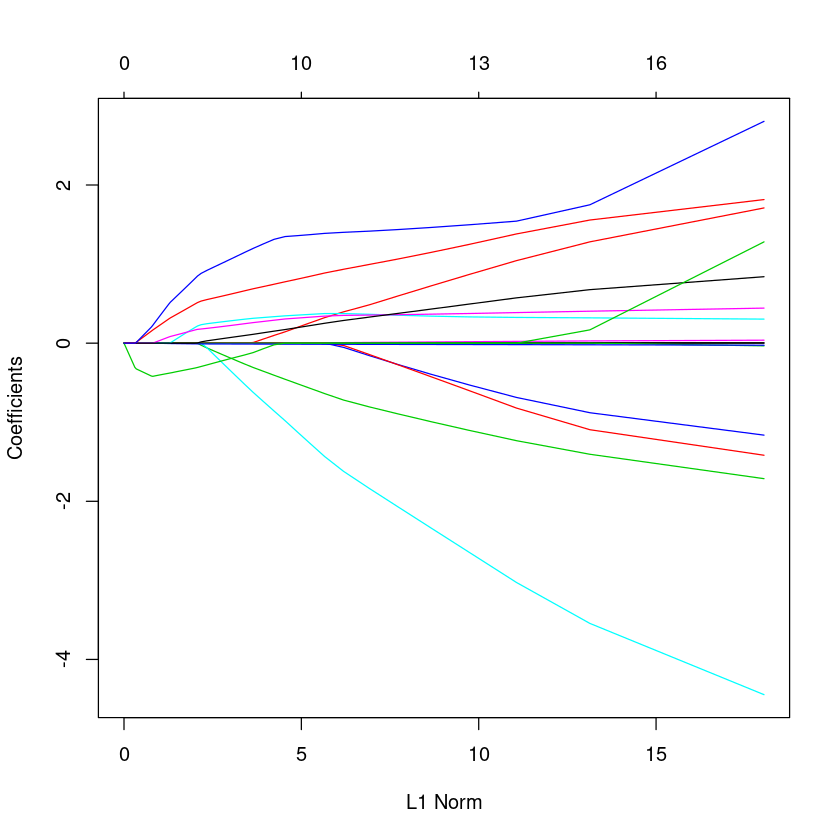

In [56]:
#Some plots based on your model:
#######

#plot Lasso based on deviance measure
plot(cvfit)  #note the x-axis in the plot is log(lambda)

#plot coefficients for various models; ignore the warning message
plot(cvfit$glmnet.fit)

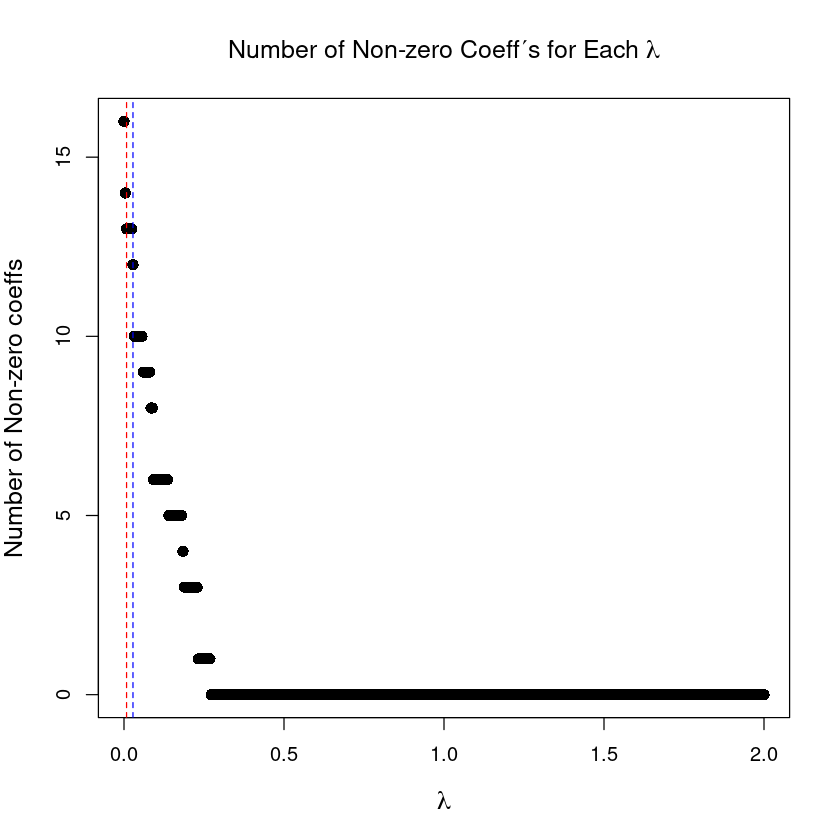

In [57]:
##Number of non-zero coefficients vs. $\lambda$

plot(cvfit$glmnet$lambda, cvfit$glmnet$df, 
     main=TeX("Number of Non-zero Coeff's for Each $\\lambda$"),pch=16,
     xlab=TeX('$\\lambda$'), ylab='Number of Non-zero coeffs', cex=1.25, cex.lab=1.25, cex.main=1.25)

abline(v=cvfit$lambda.min,col="red",lty="dashed")
abline(v=cvfit$lambda.1se,col="blue",lty="dashed")

### Part (c)

In this part you are to create `ytest`, `Xtest` and `phat` from test data, similar to the `y`, `X` and `phat` that we created above.

Create a vector of output values from the test data, and call this vector `ytest`. Also, create matrix `Xtest`, which is the predictor matrix with predictor values from the test data. `phat` should be the predicted probability of being in the `Yes` class, using the model you trained above.

**Hint:** `ytest` and `Xtest` should be just like `y` and `X`, except that you create them from the test data, rather than train data. The length of `ytest` should be 90, and the dimensions of `Xtest` should be 90 x 16.

Also, create vector `phat` using `predict()` function and the predictor values from `Xtest`.

In [37]:
# your code here
ytest = test$AHD

Xtest = test[, !(names(test) %in% c("PatientID", "AHD"))]

Xtest = model.matrix(~ ., data = Xtest)[, -1]  

phat = predict(cvfit, newx = Xtest, type = "response", s = "lambda.1se")


In [38]:
#check whether the lengths/dimensions of ytest, Xtest and phat are correct

if (test_that(desc="", code={
    expect_equal(length(ytest), 90)
    }) != TRUE) stop("Sorry, wrong answer")

if (test_that(desc="", code={
    expect_equal(dim(Xtest), c(90,16))
    }) != TRUE) stop("Sorry, wrong answer")

if (test_that(desc="", code={
    expect_equal(length(phat), 90)
    }) != TRUE) stop("Sorry, wrong answer")


Test passed 🎉
Test passed 🥇
Test passed 🥳


In [39]:
#check first couple of entries for each of the three objects

if (test_that(desc="", code={
    expect_equal(all(ytest[1:7] == c('No','Yes','No','Yes','No','No','Yes')), TRUE)
    }) != TRUE) stop("Sorry, wrong answer")

if (test_that(desc="", code={
    expect_equal(all(Xtest[1:3,1:2] == matrix(c(63,1,67,1,41,0),nrow=3,byrow=TRUE)), TRUE)
    }) != TRUE) stop("Sorry, wrong answer")

if (test_that(desc="", code={
    expect_equal(norm(phat[1:5] - c(0.156541667787126,
                                     0.9646140853973,
                                     0.141583578594962,
                                     0.415638856004774,
                                     0.359088710154446),type="2") < 1.e-5, TRUE)
    }) != TRUE) stop("Sorry, wrong answer")

Test passed 🎉
Test passed 🎉
Test passed 🌈


### ROC Curve

<br>

### Part (d)

Plot the ROC curve as a visual measure of performance of your `cvfit` model on the test data. Use `roc()` function from `pROC` library.

Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases



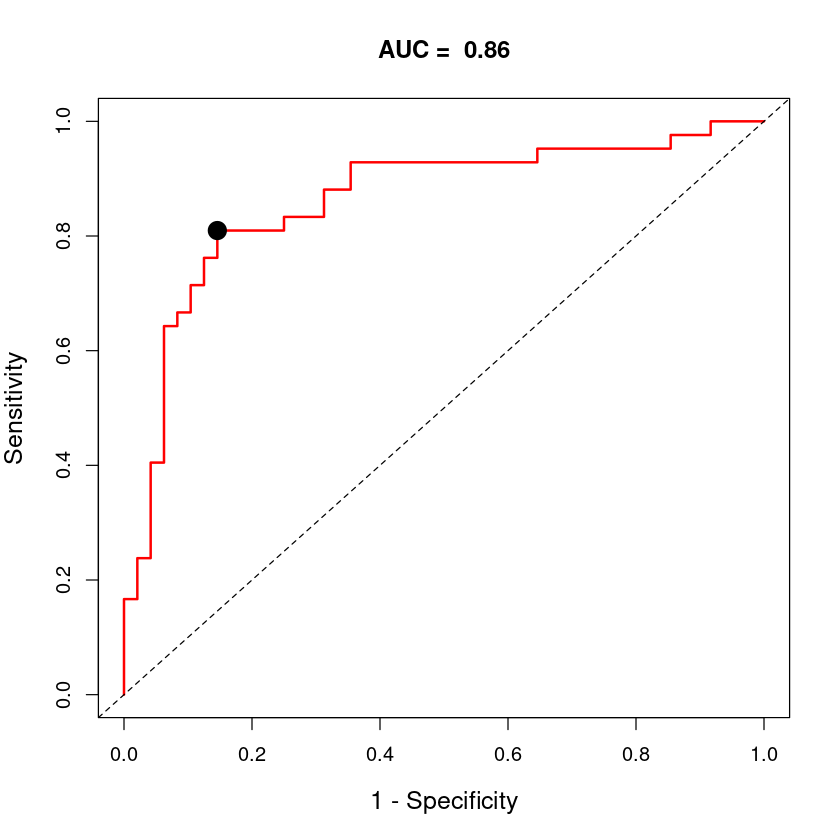

In [40]:
# your code here
#code from this same assignment
ytest_logical = (ytest == "Yes")

#Get the curve:
ROC_curve_test = roc(response = ytest_logical, predictor = as.vector(phat))

#And the area under the curve:
AUC_test = auc(ROC_curve_test)

#Can get the point closest to upper left
best_point = coords(ROC_curve_test, "best", ret = c("threshold", "sens", "spec"))

#Plot 1 - specificity
plot(x = 1 - ROC_curve_test$specificities,
     y = ROC_curve_test$sensitivities,
     main = paste("AUC = ", round(AUC_test,2)), 
     xlab = "1 - Specificity",
     ylab = "Sensitivity",
     type = "l", col="red",
     lwd = 2,
     cex = 1.25,
     cex.lab = 1.25)

abline(a = 0, b = 1, lty = "dashed") 

#Plot the point corresponding to the best cutoff
points((1 - best_point$spec), best_point$sens, pch = 21, bg = 'black', cex = 2)

### Part (d) continued

Also, create R variable `AUC` which represents the AUC (area under curve), as a quantified measure of performance. (Ignore the warning message). Do NOT round your answer.

In [41]:

# your code here
#code from this same assignment
ytest_logical = (ytest == "Yes")

ROC_curve_test = roc(response = ytest_logical, predictor = as.vector(phat))

AUC = auc(ROC_curve_test)

Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases



In [42]:
#check whether the 6th and 7th decimal digits of AUC are 71

if (test_that(desc="", code={
    expect_equal(floor(AUC*10^7) %% 100 == 71, TRUE)
    }) != TRUE) stop("Sorry, wrong answer")


Test passed 🥳


In [43]:
#check whether AUC is correct (hidden tests)



### Confusion Matrix, Accuracy, False Negative Rate

<br>

### Part (d)

Create vector `yhat` of estimated (i.e. predicted) outputs $\widehat{AHD}$ for the test data, with values "Yes" if the corresponding estimated probability of "Yes" (i.e. `pihat` entry) is greater than 0.5, and "No" otherwise. 

**Hint:** Approach this just as we did the train data.

Also, create R variable `tbl` which is of `table` type and represents confusion matrix, with `yhat` represented by columns and `ytest` by rows. Nos should be first, followed by Yeses.

**Hint:** `tbl[1,2]` should be 6. Also, the sum of all the 4 entries should equal the sample size in the test data, which is 90.



In [44]:
#creating yhat vector based on the rule: yhat=Yes if pihat>0.5; otherwise, yhat=No
#also, creating the confusion matrix tbl

# your code here
#code from this same assignment
yhat = ifelse(phat > 0.5, "Yes", "No")
tbl = table(ytest, yhat)


In [45]:
#check whether first 8 values of yhat are 'No','Yes','No','No','No','No','No','Yes'

if (test_that(desc="", code={
    expect_equal(all(yhat[1:8] == c('No','Yes','No','No','No','No','No','Yes')), TRUE)
    }) != TRUE) stop("Sorry, wrong answer")

Test passed 🥇


In [46]:
#check whether yhat is correct (hiden tests)



In [47]:
#check whether tbl[1,2] is 6

if (test_that(desc="", code={
    expect_equal(tbl[1,2]==6, TRUE)
    }) != TRUE) stop("Sorry, wrong answer")

#check whether the sum of all the entries in tbl is 90

if (test_that(desc="", code={
    expect_equal(sum(tbl), 90)
    }) != TRUE) stop("Sorry, wrong answer")

Test passed 🥇
Test passed 🎊


In [48]:
#check whether tbl is correct (hidden tests)




### Part (e)

Calculate the accuracy, i.e. the proportion of correctly predicted outputs in the test data. Store this value in the R variable `acc`.
`acc = <some expression>`

<br>

In [49]:

# your code here
#code from this same assignment
acc = (tbl[1,1]+tbl[2,2])/sum(tbl)



In [50]:
#check whether the 6th and 7th decimal digits of acc are 11

if (test_that(desc="", code={
    expect_equal(floor(acc*10^7) %% 100 == 11, TRUE)
    }) != TRUE) stop("Sorry, wrong answer")


Test passed 🌈


In [82]:
#check whether acc is correct (hidden tests)

